# Clustering using competitive learning

In [1]:
import numpy as np
import numpy.matlib
import math
import DC_Pickle as dcp

train_scores = dcp.open_Pickle('../../data/pickles/seperate_origin/eventValue.pickle')
train_scores = train_scores[:15, :]

train_data = np.ones(15)*np.nan
idx_data = []

for i in range(train_scores.shape[1]):
    if not np.isnan(train_scores[:, i]).any():
        train_data = np.vstack((train_data, train_scores[:, i]))
        idx_data.append(i)
        
train_data = numpy.delete(train_data, (0), axis=0) # delete the first row including nan
train_data = train_data.T

[n,m]  = np.shape(train_data)               # dimension and number of training data

eta    = 0.05                               # learning rate
winit  = 1                                  # initialise weight

tmax   = 40000                              # max learning iteration
clusters = 25                               # number of cluster

print(" - Dimension: {0}\n - Individuals: {1}".format(n, m))

## function for clustering with cost function return
def get_Cost(clusters_num, train):
    costs = []
    centroids = np.zeros((clusters_num, n, 10), dtype=float)
    cluster_idx = np.ones((10, m))*np.nan # 2X2 matrix to save all cluster index for each data
    
    for iter_i in range(10):
        W = winit * np.random.rand(clusters_num,n)        # Weight matrix (rows = output neurons, cols = input neurons)
        normW = np.sqrt(np.diag(W.dot(W.T)))
        normW = normW.reshape(clusters_num,-1)            # reshape normW into a numpy 2d array
        W = W / normW                               # normalise using numpy broadcasting

        normTrain = np.sqrt(np.diag(np.dot(train.T, train)))
        normTrain = normTrain.reshape(m, -1)
        train = train/normTrain.T

        counter = np.zeros((1,clusters_num))              # counter for the winner neurons
        wCount = np.ones((1,tmax+1)) * 0.25         # running avg of the weight change over time
        alpha = 0.999

        yl = int(round(clusters_num/5))                   # counter for the rows of the subplot
        if clusters_num % 5 != 0:
            yl += 1

        for t in range(1,tmax):
            i = math.ceil(m * np.random.rand())-1   # get a randomly generated index in the input range
            x = train[:,i]                          # pick a training instance using the random index

            h = W.dot(x)/clusters_num                     # get output firing
            h = h.reshape((h.shape[0],-1))          # reshape h into a numpy 2d array

            xi = np.random.rand(clusters_num,1) / 200
            k = np.argmax(h+xi)                     # get the index of the firing neuron

            counter[0,k] += 1                       # increment counter for winner neuron

            dw = eta * (x.T - W[k,:])               # calculate the change in weights for the k-th output neuron

            wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # % weight change over time (running avg)

            W[k,:] = W[k,:] + dw                    # weights for k-th output are updated

            if wCount[0, t] < 0.0001: # if it learns sufficiently with learning rate below 0.0001
                break

        ##########################################
        ## save means of clusters into the 3X3 centroids matrix
        centroids[:, :, iter_i] = W

        ##########################################
        # cluster_idx : 2X2 matrix to save all cluster index for each data
        ##########################################
        ## get indices of clusters for each data
        for data in range(m): # check all data
            min_vals = []
            for weight in range(clusters_num): # compare all clusters for a data
                diff = W[weight, :] - train[:, data] # get difference between data and clusters
                min_vals.append(sum(np.square(diff))) # get square distance

            min_idx = np.argmin(min_vals) # get cluster index which has minimum distance
            cluster_idx[iter_i, data] = min_idx # assign the index to the cluster_idx array

        # assign True and False if data belongs to specific cluster.
        for i in range(clusters_num):
            cluster_map = cluster_idx[iter_i, :] == i

            # make True and False matrix (cluster) for mapping
            cluster = cluster_map
            for j in range(14):
                cluster = np.vstack((cluster, cluster_map))
            #print(np.shape(train[cluster].reshape(n, -1)))

            for k in range(clusters_num):
                clt = "cluster{0}".format(i+1)
                globals()[clt]=train[cluster].reshape(n, -1)
            #print("cluster{0}: ".format(i), np.shape(eval("cluster{0}".format(i))))

        ##########################################
        ## Get average cost function of 10 iterations
        diff_sum = [] # all differences of clusters
        for c in range(clusters_num):
            diff_vals = [] # difference for one cluster
            clt = "cluster{0}".format(c+1)
            [n2, m2] = np.shape(eval(clt))
            for data in range(m2):
                diff = np.square(eval(clt)[:, data] - W[c, :])
                diff_vals.append(np.sum(diff))

            diff_sum.append(np.sum(diff_vals))

        costs.append(np.sum(diff_sum))

    return min(costs), centroids, cluster_idx

 - Dimension: 15
 - Individuals: 22832


# Clustering checking cost with AIC & BIC & Elbow methods

In [2]:
import time
import DC_Pickle as dcp
t0 = time.clock() # initial time

dcp.make_folders("../../data/pickles/clusters_origin/")

dimension = 15
elbow = []
AIC = []
BIC = []

for clt in range(clusters):
    set_clt_filename = "../../data/pickles/clusters_origin/centroid{0}.pickle".format(clt+1)
    set_idx_filename = "../../data/pickles/clusters_origin/index{0}.pickle".format(clt+1)
    
    [cost, cent, idx] = get_Cost(clt+1, train_data) # return cost, centroid matrix, index matrix
    
    elbow.append(cost)
    AIC.append(cost + 2*clt*dimension)
    BIC.append(cost +  clt*math.log10(15)*dimension)
    
    dcp.make_Pickle(cent, set_clt_filename, force=True)
    dcp.make_Pickle(idx, set_idx_filename, force=True)
    print("iteration ", clt+1)

print("\n - process terminal (Run time:{0})".format(time.clock()-t0))

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25

 - process terminal (Run time:8132.407944)


In [4]:
dcp.make_folders("../../data/pickles/clusters_origin/costs/")
dcp.make_Pickle(elbow, "../../data/pickles/clusters_origin/costs/elbow.pickle")
dcp.make_Pickle(AIC, "../../data/pickles/clusters_origin/costs/AIC.pickle")
dcp.make_Pickle(BIC, "../../data/pickles/clusters_origin/costs/BIC.pickle")

### Plotting

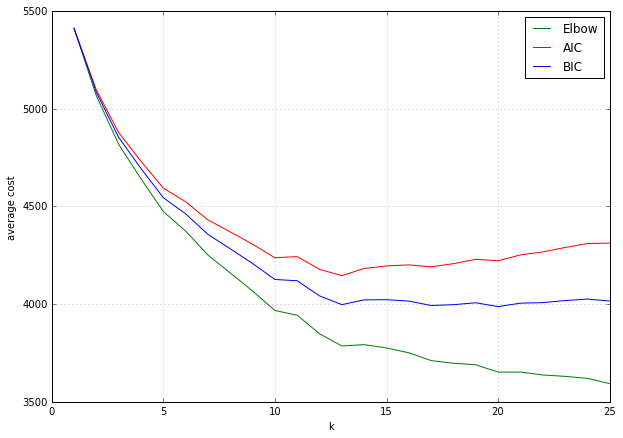

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))                                                               
ax = fig.add_subplot(1,1,1) 

ax.grid(which='both')
                                   
ax.grid(which='major', alpha=0.5)

ax.plot(np.arange(clusters)+1, elbow, 'g-', label="Elbow")
ax.plot(np.arange(clusters)+1, AIC, 'r-', label="AIC")
ax.plot(np.arange(clusters)+1, BIC, 'b-', label="BIC")
ax.set_xlabel('k')
ax.set_ylabel('average cost')
ax.legend()
fig.savefig('Figs/AIC_BIC_Elbow.png', dpi=100)